# Unit 3 capstone

In this capstone we will be trying to get some EDA from our data and then we will try to create a perfect model for this data.

For creating model we will be trying these models:
    
    1. Random Forest Regressor
    2. Gradient Boosting Regressor
    3. Linear Regressor
    4. Support Vector Regressor
    
Let's begin computing...

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tnrange, tqdm_notebook
import itertools
import time

%matplotlib inline

we will be using commodity trade data from here(https://www.kaggle.com/unitednations/global-commodity-trade-statistics). This data has 8225871 x 10 data points so it's a huge data to train models. Bigger data has advantages of higher accuracy but it takes too much time to train model.

In [2]:
df = pd.read_csv('C:/Users/vivek/Downloads/global-commodity-trade-statistics/commodity_trade_statistics_data.csv')

C:\Users\vivek\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,country_or_area,year,comm_code,commodity,flow,trade_usd,weight_kg,quantity_name,quantity,category
0,Afghanistan,2016,10410,"Sheep, live",Export,6088,2339.0,Number of items,51.0,01_live_animals
1,Afghanistan,2016,10420,"Goats, live",Export,3958,984.0,Number of items,53.0,01_live_animals
2,Afghanistan,2008,10210,"Bovine animals, live pure-bred breeding",Import,1026804,272.0,Number of items,3769.0,01_live_animals
3,Albania,2016,10290,"Bovine animals, live, except pure-bred breeding",Import,2414533,1114023.0,Number of items,6853.0,01_live_animals
4,Albania,2016,10392,"Swine, live except pure-bred breeding > 50 kg",Import,14265937,9484953.0,Number of items,96040.0,01_live_animals


In [4]:
df.shape

(8225871, 10)

## EDA

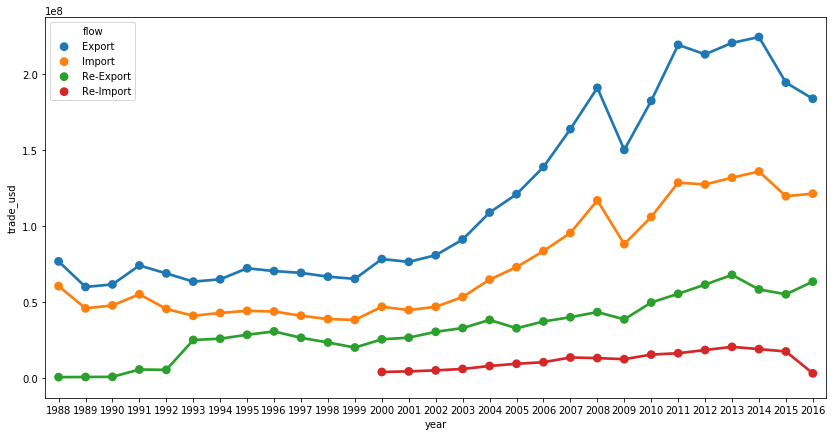

In [5]:
plt.subplots(figsize = (14,7))
sns.pointplot(y=df['trade_usd'], x=df['year'], hue=df['flow'], linestyle="--", ci=0)

Exports are highest in the time of 2014 and we can also see the effect of 2008 global financial crisis with sudden low.

In [6]:
total_trade_by_country = df.groupby(['country_or_area'])['trade_usd'].sum()

In [7]:
total_trade_by_country.nlargest(5)

country_or_area
EU-28      80560794323761
USA        73323903319056
China      61588304582650
Germany    58697172122513
Japan      37162484244900
Name: trade_usd, dtype: int64

These are top 5 countries which has highest tradings in our whole dataset.

In [8]:
new_df = df[df['country_or_area'].isin(['EU-28', 'USA', 'China', 'Germany', 'Japan', 'India'])]

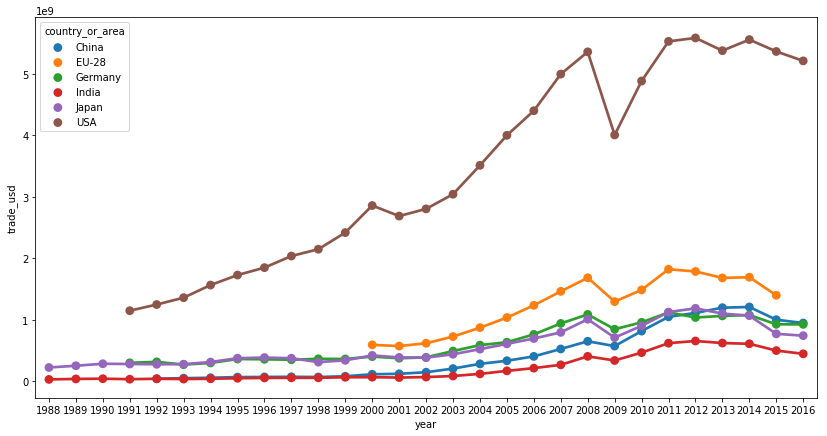

In [9]:
new_df_import = new_df[new_df['flow']=='Import']
plt.subplots(figsize = (14,7))
sns.pointplot(y=new_df_import['trade_usd'], x=new_df_import['year'], hue=new_df_import['country_or_area'], linestyle="--", ci=0)

USA is at top of every country in terms of import from 1992 and it's going gradually up except the 2008 crisis. And according to graph it is affected most by 2008 crisis. USA graph looks alot similar to export graph but with little stability after 2014.

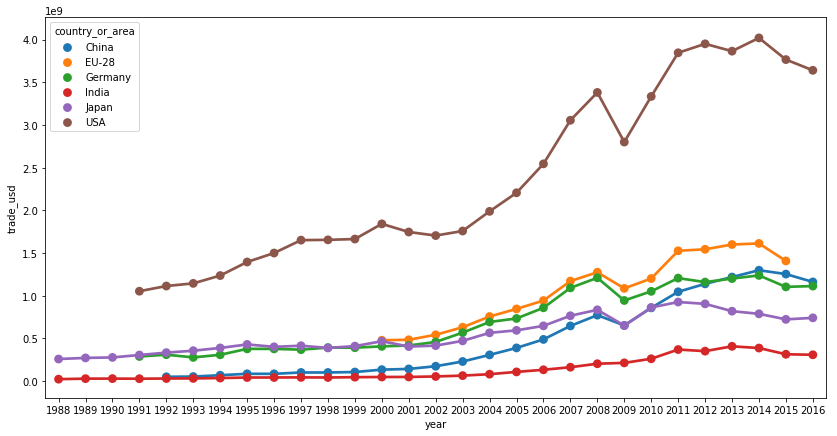

In [10]:
new_df_export = new_df[new_df['flow']=='Export']
plt.subplots(figsize = (14,7))
sns.pointplot(y=new_df_export['trade_usd'], x=new_df_export['year'], hue=new_df_export['country_or_area'], linestyle="--", ci=0)

Now in export graph the story is same for USA and mostly these countries are showing higher rate of exports than their import. But India has less exports then it's imports.

In [11]:
total_trade_by_country = df.groupby(['category'])['trade_usd'].sum()
total_trade_by_country.nlargest(7)

category
all_commodities                                    584533613000990
27_mineral_fuels_oils_distillation_products_etc     39481979738608
99_commodities_not_specified_according_to_kind      21247405876249
71_pearls_precious_stones_metals_coins_etc           9596020412058
30_pharmaceutical_products                           9304904545165
88_aircraft_spacecraft_and_parts_thereof             7984665783325
87_vehicles_other_than_railway_tramway               7796527568426
Name: trade_usd, dtype: int64

Doing same process for categories in our data we get these 7 top categories around which countries are trading.

In [12]:
new_df = df[df['category'].isin(['27_mineral_fuels_oils_distillation_products_etc', '99_commodities_not_specified_according_to_kind', '71_pearls_precious_stones_metals_coins_etc', '30_pharmaceutical_products', '88_aircraft_spacecraft_and_parts_thereof', '87_vehicles_other_than_railway_tramway'])]

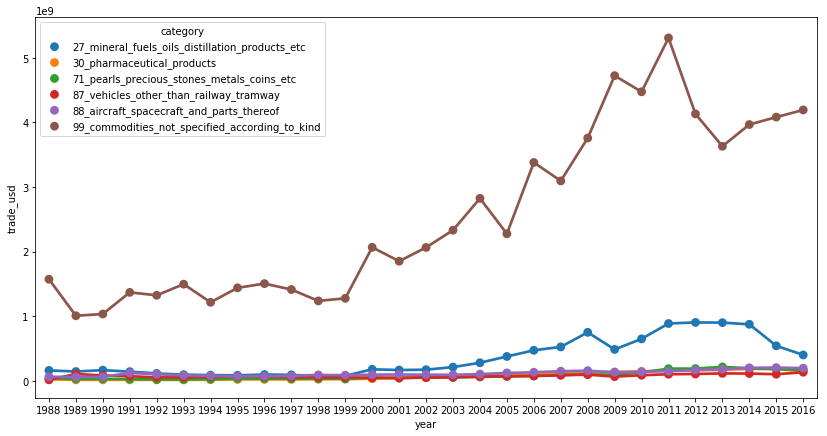

In [13]:
plt.subplots(figsize = (14,7))
sns.pointplot(y=new_df['trade_usd'], x=new_df['year'], hue=new_df['category'], linestyle="--", ci=0)

Top most category is "others", so it's obvious that it could be higher. Second category is mineral oils which is really important since last two decades. All the other categories are gradually linear.

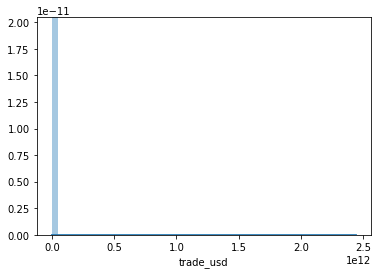

In [14]:
sns.distplot(df['trade_usd'])

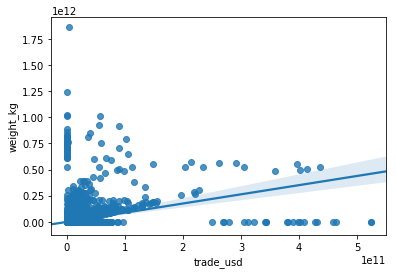

In [15]:
sns.regplot(df['trade_usd'], df['weight_kg'])

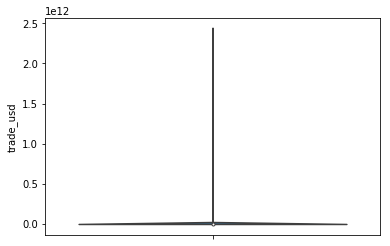

In [16]:
sns.violinplot(y=df['trade_usd'])

## Feature Selection

This section will be most important for taking out important data from dataset and creating a dataframe more suitable for higher accuracy models. First we will be dropping our Null values from the data frame.

In [3]:
df=df.dropna()

In [4]:
df.shape

(7876117, 10)

Dropping Null values decreased dataset by 4 lakh rows. Now this dataset is too big for my device to compute higher models with GridSearchCV, so i will be using half of it's rows.

In [5]:
df = df.sample(frac=0.5, random_state=11)

In [6]:
df.shape

(3938058, 10)

Next, we have 4 different categorical data columns so we will convert it into binary data columns. But 'country_or_area' has more than 200 different values so it would not be possible to run such big data in my device. So we will be skipping that column.

In [7]:
new_df = pd.concat([df, pd.get_dummies(df['flow']), pd.get_dummies(df['category']), pd.get_dummies(df['quantity_name'])], axis=1)

In [8]:
new_df.head()

,country_or_area,year,comm_code,commodity,flow,trade_usd,weight_kg,quantity_name,quantity,category,...,Length in metres,No Quantity,Number of items,Number of packages,Number of pairs,Thousands of items,Volume in cubic meters,Volume in litres,Weight in carats,Weight in kilograms
3457603,Bulgaria,2002,401091,"Conveyor belts and belting, rubber, <20cm wide",Import,2982878,1320863.0,Weight in kilograms,1320863.0,40_rubber_and_articles_thereof,...,0,0,0,0,0,0,0,0,0,1
5319523,Australia,1988,620333,"Mens, boys jackets, blazers, synthetic fibre, ...",Import,3176209,0.0,Number of items,296343.0,62_articles_of_apparel_accessories_not_knit_or...,...,0,0,1,0,0,0,0,0,0,0
6300860,Bosnia Herzegovina,2007,731990,"Articles for sewing/etc, iron/steel, except pi...",Import,23557,2635.0,Weight in kilograms,2635.0,73_articles_of_iron_or_steel,...,0,0,0,0,0,0,0,0,0,1
4767762,Jamaica,2002,560730,"Twine, cordage, ropes and cables, of abaca etc",Import,33221,13382.0,Weight in kilograms,13382.0,56_wadding_felt_nonwovens_yarns_twine_cordage_etc,...,0,0,0,0,0,0,0,0,0,1
5663803,Madagascar,2011,660390,"Parts & trimmings, of umbrella, walking sticks...",Export,1903,140.0,Weight in kilograms,140.0,66_umbrellas_walking_sticks_seat_sticks_whips_etc,...,0,0,0,0,0,0,0,0,0,1


Dropping the changed data columns.

In [9]:
new_df = new_df.drop(['country_or_area', 'commodity', 'flow', 'quantity_name', 'category'], 1)

In [10]:
new_df.head()

,year,comm_code,trade_usd,weight_kg,quantity,Export,Import,Re-Export,Re-Import,01_live_animals,...,Length in metres,No Quantity,Number of items,Number of packages,Number of pairs,Thousands of items,Volume in cubic meters,Volume in litres,Weight in carats,Weight in kilograms
3457603,2002,401091,2982878,1320863.0,1320863.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5319523,1988,620333,3176209,0.0,296343.0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6300860,2007,731990,23557,2635.0,2635.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4767762,2002,560730,33221,13382.0,13382.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5663803,2011,660390,1903,140.0,140.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
new_df.dtypes

year                                                        int64
comm_code                                                  object
trade_usd                                                   int64
weight_kg                                                 float64
quantity                                                  float64
Export                                                      uint8
Import                                                      uint8
Re-Export                                                   uint8
Re-Import                                                   uint8
01_live_animals                                             uint8
02_meat_and_edible_meat_offal                               uint8
03_fish_crustaceans_molluscs_aquatic_invertebrates_ne       uint8
04_dairy_products_eggs_honey_edible_animal_product_nes      uint8
05_products_of_animal_origin_nes                            uint8
06_live_trees_plants_bulbs_roots_cut_flowers_etc            uint8
07_edible_

Performing ususal data cleaning as some data with unusual data is present.

In [12]:
new_df = new_df[new_df['comm_code'] != '9999AA']
new_df = new_df[new_df['comm_code'] != 'TOTAL']

In [13]:
# Convert Object datatype into int64 
new_df['comm_code'] = new_df['comm_code'].astype('int64')

In [14]:
X = new_df.drop('trade_usd', 1)
Y = new_df['trade_usd']

Normalizing data from sklearn's MinMaxScaler for higher accuracy and less distortion in data.

In [15]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled_x = min_max_scaler.fit_transform(X)
df = pd.DataFrame(scaled_x)

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Splitting data into train test score for checking it's score on both ends.

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [31]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(X_test, Y_test)
print("Test data score: ", rfr.score(X_test, Y_test))

Test data score:  0.5861289964965708


For small test data 65% is fair score for Random Forest. We still need to preform PCA to lower the columns for better computation of bigger data.

In [32]:
pca = PCA(n_components=100)
pca.fit(X_train, Y_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [33]:
x_pca = pca.transform(X_train)

In [34]:
x_test_pca = pca.transform(X_test)

## Random Forest

In [35]:
start = time.time()
rfr = RandomForestRegressor(max_depth=3)
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfr = GridSearchCV(rfr, param_grid=param_grid, cv=3)
CV_rfr.fit(x_pca, Y_train)
end = time.time()
Y_pred = CV_rfr.predict(x_pca)
print("Time taken: ", end-start)
print("Best parameters: ", CV_rfr.best_params_)
print("Train data score: ", CV_rfr.score(x_pca, Y_train))
print("Test data score: ", CV_rfr.score(x_test_pca, Y_test))
print("Error: ", mean_squared_error(Y_train, Y_pred))

Time taken:  12266.58833527565
Best parameters:  {'max_features': 'auto', 'n_estimators': 30}
Train data score:  0.7523987263291911
Test data score:  0.408830270615946
Error:  1.236786804189933e+17


73% on train data and 63% of test data looks good but let's try if we can increase accuracy with another model.

## Gradient Boosting

In [36]:
start = time.time()
gbr = GradientBoostingRegressor(n_estimators=10)
param_grid = {
    'n_estimators': [10, 20, 40],
    "max_features":["log2","sqrt"]
}
CV_gbr = GridSearchCV(gbr, param_grid=param_grid, cv=3)
CV_gbr.fit(x_pca, Y_train)
end = time.time()
Y_pred = CV_gbr.predict(x_pca)
print("Time taken: ", end-start)
print("Best parameters: ", CV_gbr.best_params_)
print("Train data score: ", CV_gbr.score(x_pca, Y_train))
print("Test data score: ", CV_gbr.score(x_test_pca, Y_test))
print("Error: ", mean_squared_error(Y_train, Y_pred))

Time taken:  2542.534558534622
Best parameters:  {'max_features': 'sqrt', 'n_estimators': 40}
Train data score:  0.7431452368613753
Test data score:  0.41263357780700366
Error:  1.2830086733137597e+17


Accuracy inccreased with 76% in train data and 68% in test data using Gradient Boosting. It performed better than Random Forest.

## Linear Regression

In [37]:
start = time.time()
reg = LinearRegression()
reg.fit(x_pca, Y_train)
end = time.time()
Y_pred = reg.predict(x_pca)
print("Time taken: ", end-start)
print("Train data score: ", reg.score(x_pca, Y_train))
print("Test data score: ", reg.score(x_test_pca, Y_test))
print("Error: ", mean_squared_error(Y_train, Y_pred))

Time taken:  30.814231872558594
Train data score:  0.20929480689334323
Test data score:  0.10792790986050549
Error:  3.949631334041315e+17


Linear Regression score is too bad for comparing with other models.

## SVR

In [ ]:
start = time.time()
svr = SVR()
param_grid={
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'gamma': ['scale', 'auto']
}
CV_svr = GridSearchCV(svr, param_grid=param_grid, cv=3)
CV_svr.fit(x_pca, Y_train)
end = time.time()
print("Time taken: ", end-start)
print("Train data score: ", CV_svr.score(x_pca, Y_train))
print("Test data score: ", CV_svr.score(x_test_pca, Y_test))

I tried running SVR for more than 12 hours but no output was shown so i am skipping it for now.

# Without Normalization

We will perform same process as above but without normalization so the data is not changed.

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [57]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(X_test, Y_test)
print("Test data score: ", rfr.score(X_test, Y_test))

Test data score:  0.5908877247375999


In [58]:
pca = PCA(n_components=100)
pca.fit(X_train, Y_train)
x_pca = pca.transform(X_train)
x_test_pca = pca.transform(X_test)

In [59]:
rfr = RandomForestRegressor(max_depth=3)
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfr = GridSearchCV(rfr, param_grid=param_grid, cv=3)
CV_rfr.fit(x_pca, Y_train)
Y_pred = CV_rfr.predict(x_pca)
print("Best parameters: ", CV_rfr.best_params_)
print("Train data score: ", CV_rfr.score(x_pca, Y_train))
print("Test data score: ", CV_rfr.score(x_test_pca, Y_test))
print("Error: ", mean_squared_error(Y_train, Y_pred))

Best parameters:  {'max_features': 'auto', 'n_estimators': 20}
Train data score:  0.7540114358841601
Test data score:  0.15151826287102665
Error:  1.2243741410352488e+17


In [60]:
start = time.time()
gbr = GradientBoostingRegressor(n_estimators=10)
param_grid = {
    'n_estimators': [10, 20, 40],
    "max_features":["log2","sqrt"]
}
CV_gbr = GridSearchCV(gbr, param_grid=param_grid, cv=3)
CV_gbr.fit(x_pca, Y_train)
end = time.time()
Y_pred = CV_gbr.predict(x_pca)
print("Time taken: ", end-start)
print("Best parameters: ", CV_gbr.best_params_)
print("Train data score: ", CV_gbr.score(x_pca, Y_train))
print("Test data score: ", CV_gbr.score(x_test_pca, Y_test))
print("Error: ", mean_squared_error(Y_train, Y_pred))

Time taken:  2467.4166672229767
Best parameters:  {'max_features': 'sqrt', 'n_estimators': 40}
Train data score:  0.7674497888534726
Test data score:  0.44729501298208796
Error:  1.157486593100369e+17


In [61]:
start = time.time()
reg = LinearRegression()
reg.fit(x_pca, Y_train)
end = time.time()
Y_pred = reg.predict(x_pca)
print("Time taken: ", end-start)
print("Train data score: ", reg.score(x_pca, Y_train))
print("Test data score: ", reg.score(x_test_pca, Y_test))
print("Error: ", mean_squared_error(Y_train, Y_pred))

Time taken:  18.092053413391113
Train data score:  0.22836376947828418
Test data score:  -0.05873914771407329
Error:  3.840712881643536e+17


Without normalization our models are overfitting to the data. So we will use normalization for final model.

In [ ]:
start = time.time()
svr = SVR()
param_grid={
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
CV_svr = GridSearchCV(svr, param_grid=param_grid, cv=2)
CV_svr.fit(x_pca, Y_train)
end = time.time()
print("Time taken: ", end-start)
print("Best parameters: ", CV_svr.best_params_)
print("Train data score: ", CV_svr.score(x_pca, Y_train))
print("Test data score: ", CV_svr.score(x_test_pca, Y_test))

# Conclusion

In conclusion Gradient Boosting is performing best with normalization. I think score could be further increased if we increase the number of columns by using 'country_or_area' and also by inluding the rows we skipped just because of less computation power.

It could be increased to around 80% if we have more computation power and we can also include max_depth in GridSearchCV.

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled_x = min_max_scaler.fit_transform(X)
df = pd.DataFrame(scaled_x)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [32]:
pca = PCA(10)
pca.fit(X_train, Y_train)
x_pca = pca.transform(X_train)
x_test_pca = pca.transform(X_test)

In [43]:
x_df = pd.DataFrame(x_pca)[:500000]
Y_train = Y_train[:500000]
x_df_test = pd.DataFrame(x_test_pca)
print(x_df.head())

              0             1              2         3         4         5  \
0 -5.493877e+08 -3.452555e+07 -137122.847263 -7.349237 -0.876606 -0.140836   
1 -5.509326e+08 -3.606739e+07  353284.535144 -4.521695  0.536470 -0.354452   
2 -5.506003e+08 -3.573576e+07 -356413.116936 -5.274935 -0.189109 -0.020869   
3 -5.509367e+08 -3.607076e+07  463093.531606 -4.562301  0.520917  0.974518   
4 -5.509378e+08 -3.607263e+07 -386506.470349 -0.261989 -0.871770 -0.026702   

          6         7         8         9  
0 -0.084509  0.016658  0.003924 -0.033572  
1 -0.054011  0.050236 -0.043568 -0.030515  
2  0.525517 -0.062646  0.007045  0.037644  
3 -0.094421 -0.335559 -0.032328 -0.015808  
4 -0.076560 -0.058633  0.051499 -0.003688  


In [45]:
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []
for k in tnrange(1,len(x_df.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(x_df.columns,k):
        gbr = GradientBoostingRegressor(n_estimators=20, max_features='sqrt')
        gbr.fit(x_df[list(combo)], Y_train)
        Y_pred = gbr.predict(x_df[list(combo)])
        RSS_list.append(mean_squared_error(Y_train, Y_pred))
        R_squared_list.append(gbr.score(x_df[list(combo)], Y_train))
        feature_list.append(combo)
        numb_features.append(len(combo))

In [46]:
errors_df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [48]:
df_min = errors_df[errors_df.groupby('numb_features')['RSS'].transform(min) == errors_df['RSS']]
df_max = errors_df[errors_df.groupby('numb_features')['R_squared'].transform(max) == errors_df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))

,numb_features,RSS,R_squared,features
1,1,8.748202e+16,0.696881,"(1,)"
20,2,8.370784e+16,0.709958,"(1, 3)"
98,3,8.095415e+16,0.719499,"(1, 3, 4)"


,numb_features,RSS,R_squared,features
1,1,8.748202e+16,0.696881,"(1,)"
20,2,8.370784e+16,0.709958,"(1, 3)"
98,3,8.095415e+16,0.719499,"(1, 3, 4)"


In [50]:
errors_df['min_RSS'] = errors_df.groupby('numb_features')['RSS'].transform(min)
errors_df['max_R_squared'] = errors_df.groupby('numb_features')['R_squared'].transform(max)
errors_df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,8.965506e+16,0.689351,"(0,)",8.748202e+16,0.696881
1,1,8.748202e+16,0.696881,"(1,)",8.748202e+16,0.696881
2,1,1.501988e+17,0.479571,"(2,)",8.748202e+16,0.696881
3,1,1.535634e+17,0.467913,"(3,)",8.748202e+16,0.696881
4,1,9.938309e+16,0.655644,"(4,)",8.748202e+16,0.696881


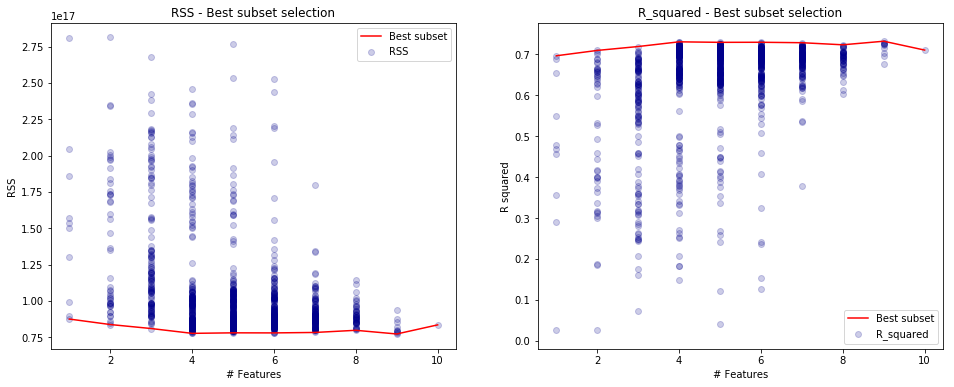

In [51]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(errors_df.numb_features,errors_df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(errors_df.numb_features,errors_df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(errors_df.numb_features,errors_df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(errors_df.numb_features,errors_df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()